In [1]:
 # All imports
import numpy as np
import pandas as pd 
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = "/kaggle/input/llm-classification-finetuning"

# getting file paths from the directory
file_paths = {"train.csv": "", "test.csv": ""}
for dirname, _, filenames in os.walk(data):
    for filename in filenames:
        fullpath = os.path.join(dirname, filename)
        # print(fullpath)
        if filename in file_paths:
            file_paths[filename] = fullpath

file_paths

{'train.csv': '/kaggle/input/llm-classification-finetuning/train.csv',
 'test.csv': '/kaggle/input/llm-classification-finetuning/test.csv'}

In [3]:
# reading data from file
train_df = pd.read_csv(file_paths['train.csv'])
test_df = pd.read_csv(file_paths['test.csv'])

train_df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [4]:
test_df.head()

,id,prompt,response_a,response_b
0,136060,"[""I have three oranges today, I ate an orange ...","[""You have two oranges today.""]","[""You still have three oranges. Eating an oran..."
1,211333,"[""You are a mediator in a heated political deb...","[""Thank you for sharing the details of the sit...","[""Mr Reddy and Ms Blue both have valid points ..."
2,1233961,"[""How to initialize the classification head wh...","[""When you want to initialize the classificati...","[""To initialize the classification head when p..."


In [5]:
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (57477, 9)
Test shape: (3, 4)


In [6]:
# Check for missing values
print("\nMissing values:")
print(train_df.isnull().sum())


Missing values:
id                0
model_a           0
model_b           0
prompt            0
response_a        0
response_b        0
winner_model_a    0
winner_model_b    0
winner_tie        0
dtype: int64


In [7]:
# converting key columns into strings, joining all the items in the list & removing None in list
def preprocess_data(df):
    
    df["prompt"] = df["prompt"].apply(lambda x: ' '.join(json.loads(x)))
    df["response_a"] = df["response_a"].apply(lambda x: ' '.join([i for i in json.loads(x) if i is not None]))
    df["response_b"] = df["response_b"].apply(lambda x: ' '.join([i for i in json.loads(x) if i is not None]))

    return df

train_df = preprocess_data(train_df)
train_df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...,0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...,1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...,0,1,0


In [8]:
test_df = preprocess_data(test_df)
test_df.head()

,id,prompt,response_a,response_b
0,136060,"I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...
1,211333,You are a mediator in a heated political debat...,Thank you for sharing the details of the situa...,Mr Reddy and Ms Blue both have valid points in...
2,1233961,How to initialize the classification head when...,When you want to initialize the classification...,To initialize the classification head when per...


In [9]:
# create labels
label = []
for index, row in train_df.iterrows():
    if row["winner_model_a"] == 1:
        label.append(0)
    elif row["winner_model_b"] == 1:
        label.append(1)
    else:
        label.append(2) 


train_df["label"] = label

train_df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,label
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0,0
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0,1
2,65089,gpt-3.5-turbo-0613,mistral-medium,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...,0,0,1,2
3,96401,llama-2-13b-chat,mistral-7b-instruct,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...,1,0,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...,0,1,0,1


In [10]:
# display label distribution
print(f"Label distribution: \n {train_df['label'].value_counts()}")

Label distribution: 
 label
0    20064
1    19652
2    17761
Name: count, dtype: int64


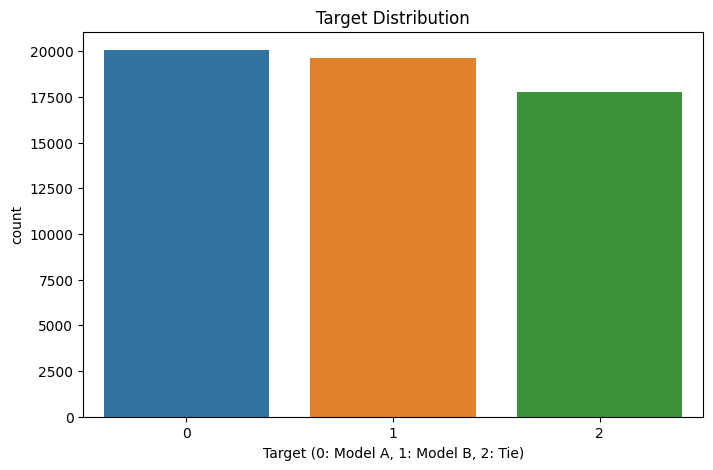

In [11]:
# Visualize distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='label')
plt.title('Target Distribution')
plt.xlabel('Target (0: Model A, 1: Model B, 2: Tie)')
plt.show()

In [12]:
# Text length analysis
def analyze_text_lengths(df):
    """Analyze text lengths to optimize max_length parameter"""
    df['prompt_len'] = df['prompt'].str.len()
    df['response_a_len'] = df['response_a'].str.len()
    df['response_b_len'] = df['response_b'].str.len()
    df['total_len'] = df['prompt_len'] + df['response_a_len'] + df['response_b_len']
    
    print("Text length statistics:")
    print(f"Prompt length - Mean: {df['prompt_len'].mean():.0f}, Max: {df['prompt_len'].max()}")
    print(f"Response A length - Mean: {df['response_a_len'].mean():.0f}, Max: {df['response_a_len'].max()}")
    print(f"Response B length - Mean: {df['response_b_len'].mean():.0f}, Max: {df['response_b_len'].max()}")
    print(f"Total length - Mean: {df['total_len'].mean():.0f}, Max: {df['total_len'].max()}")
    print(f"95th percentile total length: {df['total_len'].quantile(0.95):.0f}")
    
    return df

train_df = analyze_text_lengths(train_df)

Text length statistics:
Prompt length - Mean: 352, Max: 32833
Response A length - Mean: 1330, Max: 53299
Response B length - Mean: 1337, Max: 52402
Total length - Mean: 3020, Max: 75593
95th percentile total length: 7926


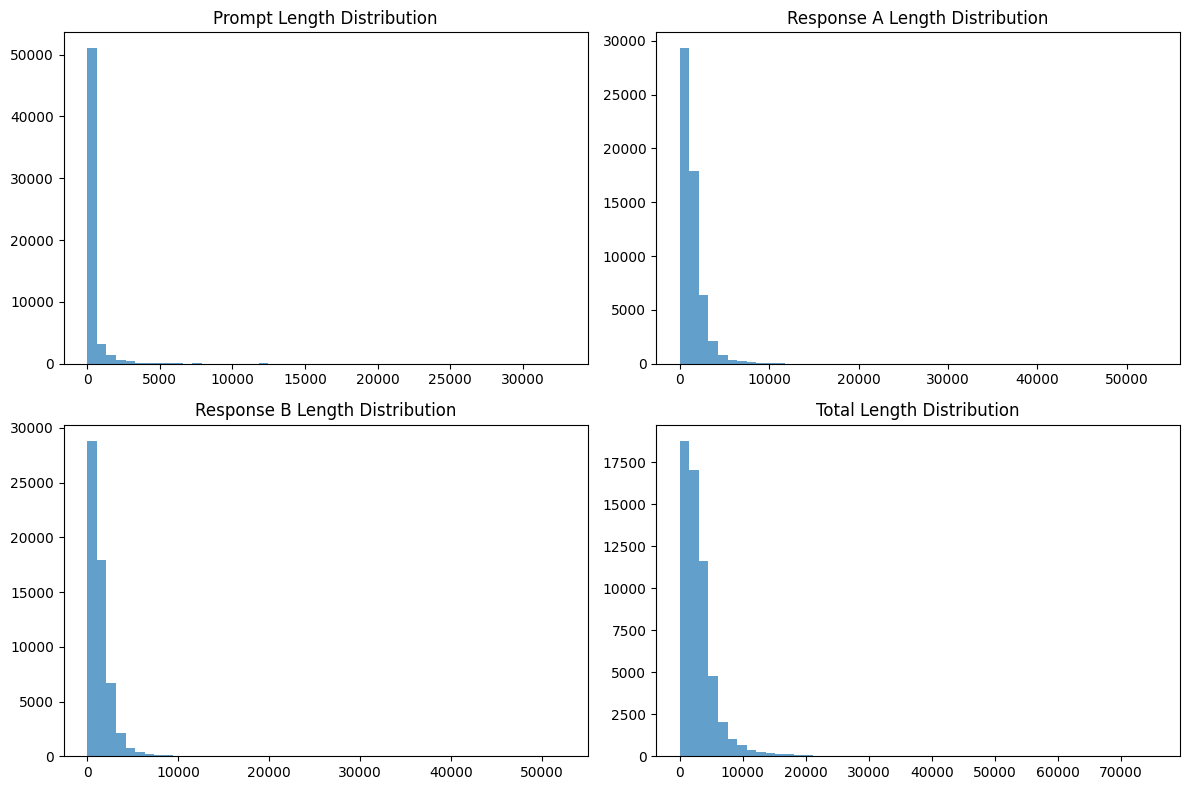

In [13]:
# Plot length distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0,0].hist(train_df['prompt_len'], bins=50, alpha=0.7)
axes[0,0].set_title('Prompt Length Distribution')
axes[0,1].hist(train_df['response_a_len'], bins=50, alpha=0.7)
axes[0,1].set_title('Response A Length Distribution')
axes[1,0].hist(train_df['response_b_len'], bins=50, alpha=0.7)
axes[1,0].set_title('Response B Length Distribution')
axes[1,1].hist(train_df['total_len'], bins=50, alpha=0.7)
axes[1,1].set_title('Total Length Distribution')
plt.tight_layout()
plt.show()

In [14]:
class CFG:
    
    # Model settings
    model_name = "microsoft/deberta-v3-small"
    max_length = 1024
    
    # Training settings  
    batch_size = 8  # Adjust based on GPU memory
    gradient_accumulation_steps = 4  # Effective batch size = 32
    learning_rate = 2e-5
    weight_decay = 0.01
    num_epochs = 3
    warmup_ratio = 0.1
    
    # CV settings
    n_splits = 5
    seed = 42
    
    # Other
    num_workers = 2
    save_steps = 1000
    eval_steps = 500
    max_grad_norm = 1.0
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Set seeds for reproducibility
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG.seed)

In [16]:
# Dataset class
class PreferenceDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=1024, is_train=True):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_train = is_train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Create input text
        prompt = row['prompt']
        response_a = row['response_a']
        response_b = row['response_b']
        
        # Format: [CLS] prompt [SEP] response_a [SEP] response_b [SEP]
        text = f"{prompt} {self.tokenizer.sep_token} {response_a} {self.tokenizer.sep_token} {response_b}"
        
        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }
        
        # Add labels for training data
        if self.is_train and 'label' in self.df.columns:
            item['labels'] = torch.tensor(row['label'], dtype=torch.long)
            
        return item